In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
!pip install ycimpute
!pip install category_encoders
from ycimpute.imputer import knnimput
from category_encoders import MEstimateEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submisssion = pd.read_csv("sample_submission.csv")

In [ ]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
train_data.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,8693,8693,0001_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CryoSleep,8476,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cabin,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,8490,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0


### **Mutual Information**

In [ ]:
#Copy for protect original of data
df = train_data.copy()

In [ ]:
X = df.copy()
y = X.pop("Transported")

In [ ]:
#Temporary convert for operation of Mutual Information
for col_name in X.select_dtypes(["object"]):
    X[col_name], _ = X[col_name].factorize()

In [ ]:
#Temporary fill missing values for operation of Mutual Information
X = X.apply(lambda x: x.fillna(x.mean())).astype(int)


In [ ]:
features = X.dtypes == int

In [ ]:
def MakeMiScore(X,y,disc_features):
    mi_scores = mutual_info_classif(X,y, discrete_features=disc_features)
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores

In [ ]:
print(MakeMiScore(X,y,features))

PassengerId     0.693121
Name            0.675740
Cabin           0.542349
FoodCourt       0.156348
Spa             0.145030
RoomService     0.143630
VRDeck          0.134813
ShoppingMall    0.129106
CryoSleep       0.113554
HomePlanet      0.018931
Age             0.015482
Destination     0.006161
VIP             0.000702
Name: MI Scores, dtype: float64


In [ ]:
def PlotScores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

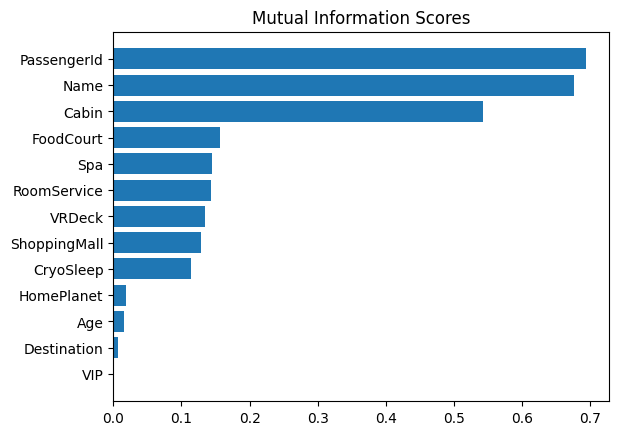

In [ ]:
PlotScores(MakeMiScore(X,y,features))

In [ ]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### **Transported**

True     0.503624
False    0.496376
Name: Transported, dtype: float64


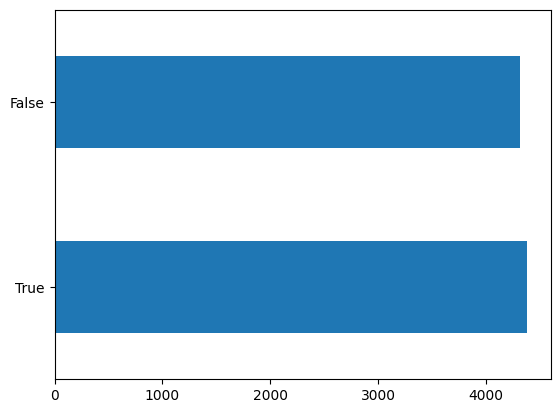

In [ ]:
print(train_data.Transported.value_counts(normalize = True))
train_data.Transported.value_counts().plot.barh();

### **HomePlanet**

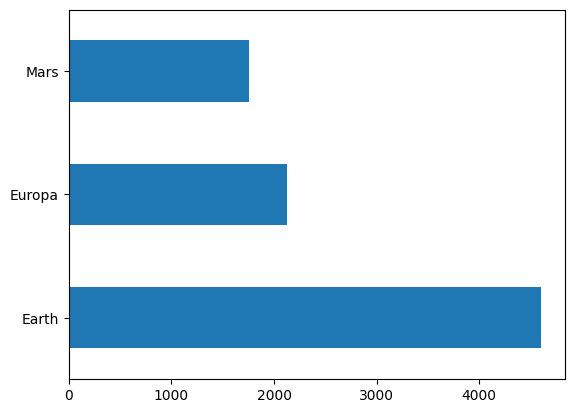

In [ ]:
train_data.HomePlanet.value_counts().plot.barh();

HomePlanet  Transported
Earth       False          0.576054
            True           0.423946
Europa      True           0.658846
            False          0.341154
Mars        True           0.523024
            False          0.476976
Name: Transported, dtype: float64


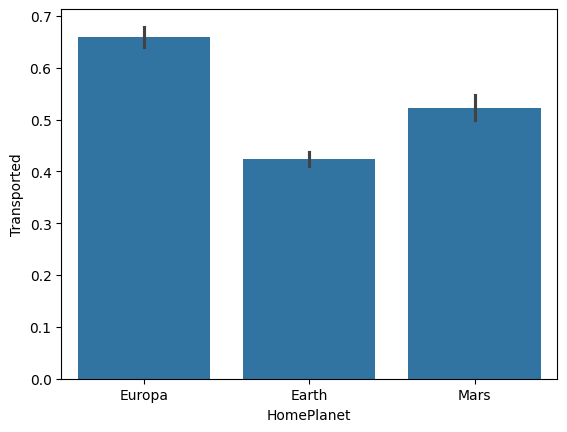

In [ ]:
print(train_data.groupby("HomePlanet")["Transported"].value_counts(normalize=True))
sns.barplot(x = "HomePlanet", y= "Transported", data = df);

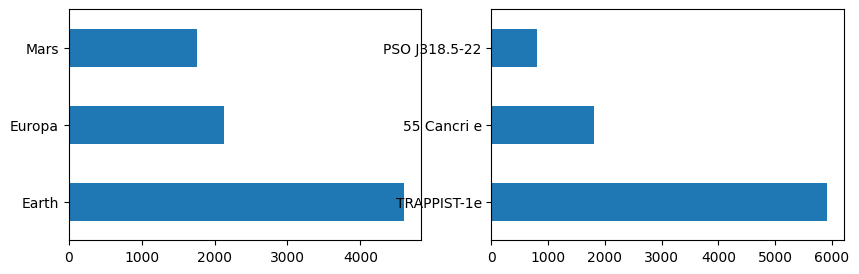

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(121)
train_data["HomePlanet"].value_counts().plot.barh()
plt.subplot(122)
train_data["Destination"].value_counts().plot.barh()
plt.show()

In [ ]:
train_data.groupby("HomePlanet")["Destination"].value_counts(normalize=True)

HomePlanet  Destination  
Earth       TRAPPIST-1e      0.688652
            PSO J318.5-22    0.158117
            55 Cancri e      0.153231
Europa      TRAPPIST-1e      0.567813
            55 Cancri e      0.423114
            PSO J318.5-22    0.009074
Mars        TRAPPIST-1e      0.859056
            55 Cancri e      0.112405
            PSO J318.5-22    0.028538
Name: Destination, dtype: float64

HomePlanet  VIP  
Earth       False    1.000000
Europa      False    0.937291
            True     0.062709
Mars        False    0.963287
            True     0.036713
Name: VIP, dtype: float64


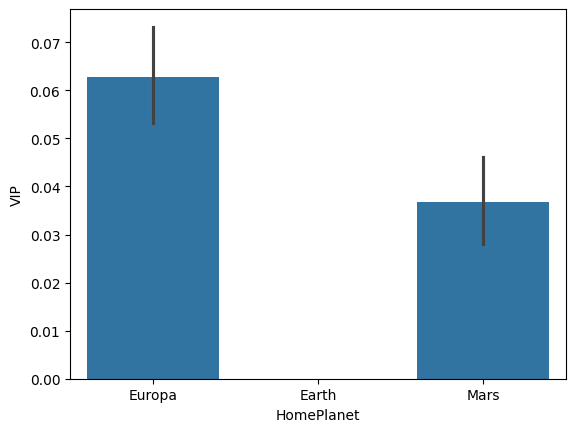

In [ ]:
print(train_data.groupby("HomePlanet")["VIP"].value_counts(normalize=True))
sns.barplot(train_data, x ="HomePlanet",y = "VIP");

<Axes: xlabel='HomePlanet', ylabel='Transported'>

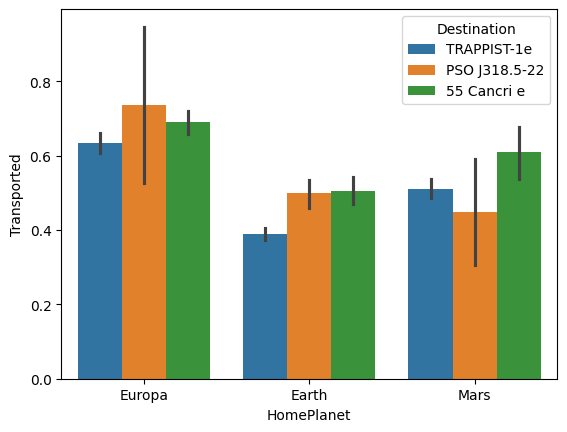

In [ ]:
sns.barplot(x = "HomePlanet", y= "Transported", data = train_data, hue = "Destination")

# **Observe**
- Ratio of Transported passengers and
untransported passengers almost same.
- Passengers whose Homeplanet is Earth more after Europa and Mars respectively.
- Homeplanet is effective in Transported. - Passengers in Europa are more transported others.
- There aren't VIP passenger in Earth.


# **CryoSleep**

False    0.641694
True     0.358306
Name: CryoSleep, dtype: float64


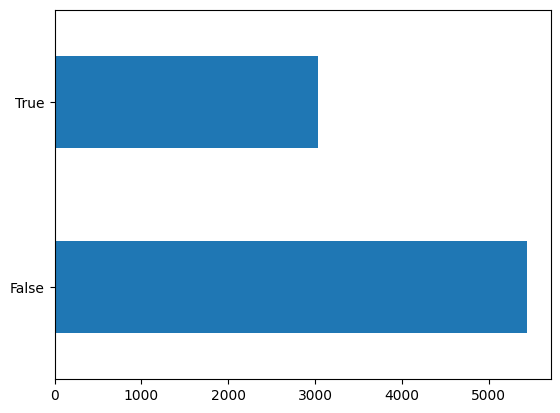

In [ ]:
print(train_data["CryoSleep"].value_counts(normalize = True))
train_data["CryoSleep"].value_counts().plot.barh();

In [ ]:
print(train_data.groupby("CryoSleep")["VIP"].value_counts(normalize = True))

CryoSleep  VIP  
False      False    0.967093
           True     0.032907
True       False    0.992910
           True     0.007090
Name: VIP, dtype: float64


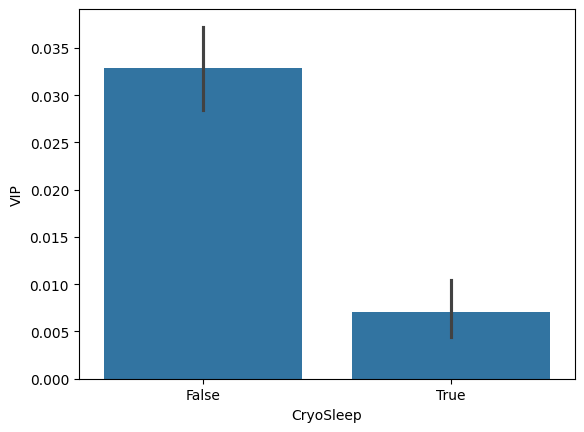

In [ ]:
sns.barplot(x= "CryoSleep", y= "VIP", data = train_data);

CryoSleep  Transported
False      False          0.671079
           True           0.328921
True       True           0.817583
           False          0.182417
Name: Transported, dtype: float64


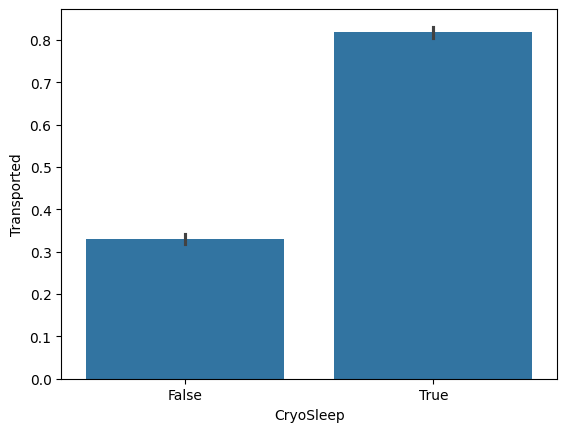

In [ ]:
print(train_data.groupby("CryoSleep")["Transported"].value_counts(normalize = True))
sns.barplot(x = "CryoSleep", y= "Transported", data = train_data);

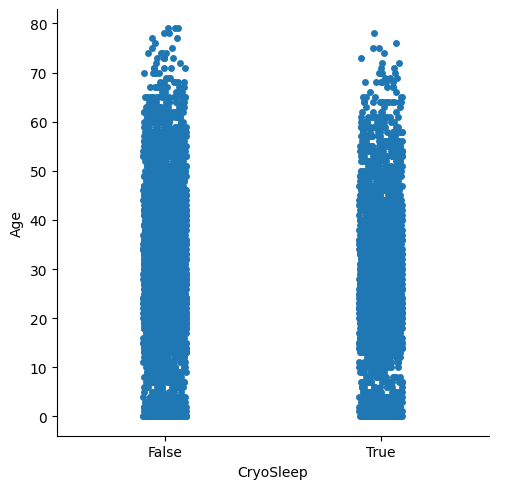

In [ ]:
sns.catplot(x = "CryoSleep",y= "Age", data = train_data)

In [ ]:
train_data.groupby("CryoSleep")[["Spa", "VRDeck", "ShoppingMall", "RoomService", "FoodCourt"]].aggregate(["min", "max"])

Spa          VRDeck          ShoppingMall          RoomService  \
           min      max    min      max          min      max         min   
CryoSleep                                                                   
False      0.0  22408.0    0.0  24133.0          0.0  23492.0         0.0   
True       0.0      0.0    0.0      0.0          0.0      0.0         0.0   

                   FoodCourt           
               max       min      max  
CryoSleep                              
False      14327.0       0.0  29813.0  
True           0.0       0.0      0.0

In [ ]:
train_data.groupby("CryoSleep")["HomePlanet"].value_counts(normalize = True)

CryoSleep  HomePlanet
False      Earth         0.584384
           Europa        0.218627
           Mars          0.196990
True       Earth         0.466577
           Europa        0.307562
           Mars          0.225861
Name: HomePlanet, dtype: float64

In [ ]:
train_data.groupby("CryoSleep")["Destination"].value_counts(normalize = True)

CryoSleep  Destination  
False      TRAPPIST-1e      0.734225
           55 Cancri e      0.191561
           PSO J318.5-22    0.074214
True       TRAPPIST-1e      0.624624
           55 Cancri e      0.247240
           PSO J318.5-22    0.128137
Name: Destination, dtype: float64

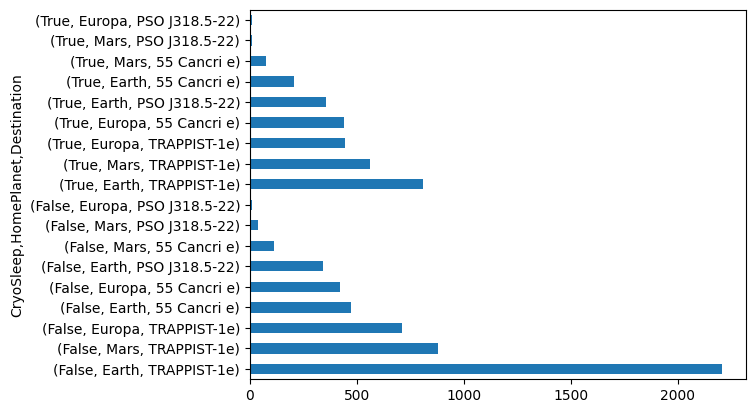

In [ ]:
train_data.groupby("CryoSleep")[["HomePlanet", "Destination"]].value_counts().plot.barh();

## **Observe**
- 35 percent of passengers are sleeping.
- VIP and Age are not effective in CryoSleep but CryoSleep has higher positive corelation with transported.
- Sleeping passengers didn't spend money therefore missing values can fill this situation.

## **Destination**

<Axes: >

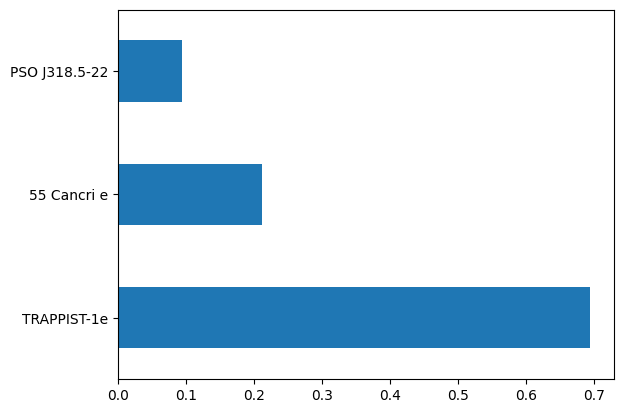

In [ ]:
train_data["Destination"].value_counts(normalize = True).plot.barh()

<Axes: xlabel='Destination', ylabel='VIP'>

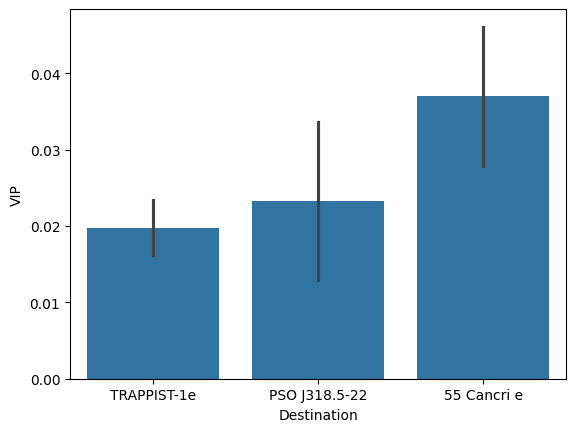

In [ ]:
sns.barplot(x = "Destination", y= "VIP", data = train_data)

In [ ]:
print(train_data.groupby("Destination")["VIP"].value_counts(normalize=True))

Destination    VIP  
55 Cancri e    False    0.963005
               True     0.036995
PSO J318.5-22  False    0.976744
               True     0.023256
TRAPPIST-1e    False    0.980280
               True     0.019720
Name: VIP, dtype: float64


Destination    Transported
55 Cancri e    True           0.610000
               False          0.390000
PSO J318.5-22  True           0.503769
               False          0.496231
TRAPPIST-1e    False          0.528825
               True           0.471175
Name: Transported, dtype: float64


<Axes: xlabel='Destination', ylabel='Transported'>

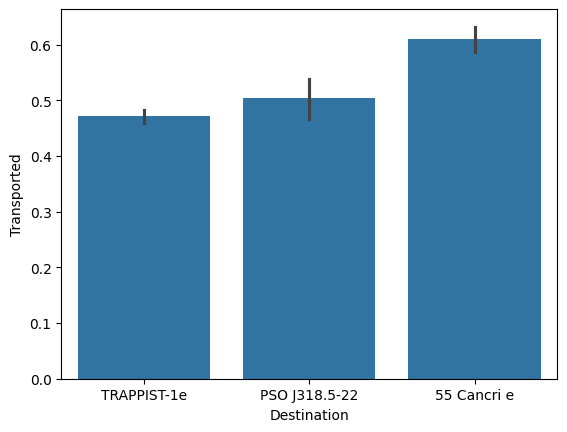

In [ ]:
print(train_data.groupby("Destination")["Transported"].value_counts(normalize = True))
sns.barplot(x = "Destination", y= "Transported", data=train_data)

<Axes: xlabel='Destination', ylabel='Transported'>

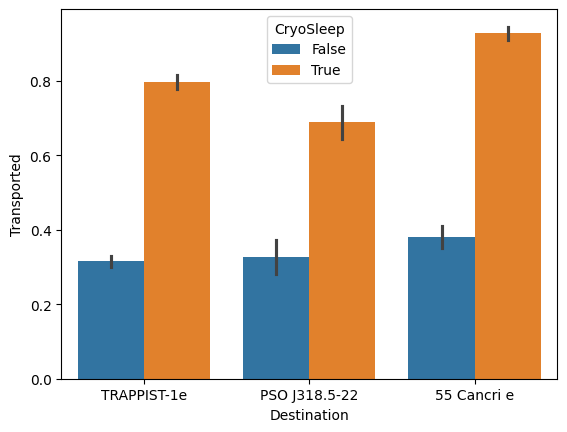

In [ ]:
sns.barplot(x = "Destination", y= "Transported", hue = "CryoSleep",data=train_data)


## **Observe**
- Situation of VIP is not effective Destination
- Those with destination 55 Cancri-e are relatively more likely to be reached than others. This reason for this situation 55 cancri-e passengers may have relatively high sleeping rate.

## **Age**

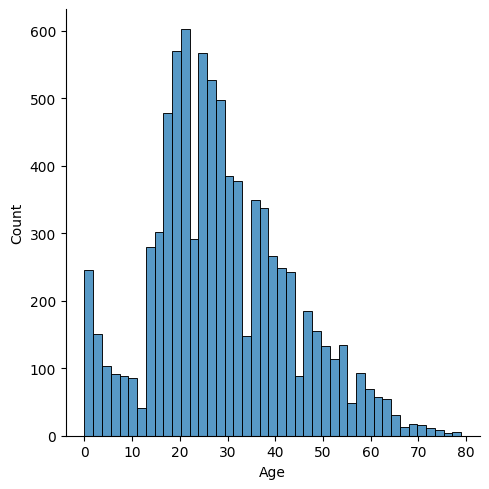

In [ ]:
sns.displot(train_data["Age"])

<Axes: xlabel='Age', ylabel='RoomService'>

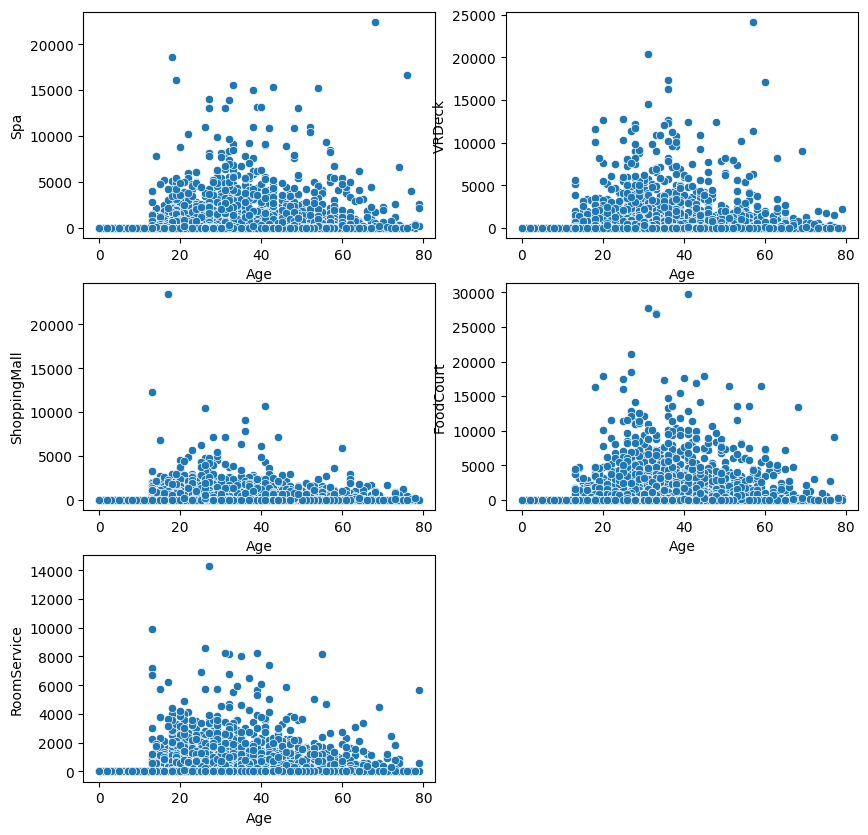

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(321)
sns.scatterplot(x = "Age", y = "Spa", data = train_data)
plt.subplot(322)
sns.scatterplot(x = "Age", y = "VRDeck", data = train_data)
plt.subplot(323)
sns.scatterplot(x = "Age", y = "ShoppingMall", data = train_data)
plt.subplot(324)
sns.scatterplot(x = "Age", y = "FoodCourt", data = train_data)
plt.subplot(325)
sns.scatterplot(x = "Age", y = "RoomService", data = train_data)

In [ ]:
print(train_data[train_data["Spa"]>0]["Age"].min())
print(train_data[train_data["VRDeck"]>0]["Age"].min())
print(train_data[train_data["FoodCourt"]>0]["Age"].min())
print(train_data[train_data["RoomService"]>0]["Age"].min())
print(train_data[train_data["ShoppingMall"]>0]["Age"].min())

13.0
13.0
13.0
13.0
13.0


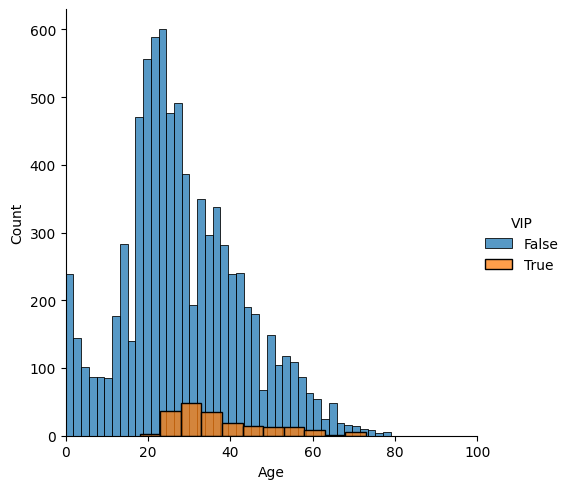

In [ ]:
(sns
.FacetGrid(train_data, hue = "VIP", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend()

In [ ]:
train_data.groupby("VIP")["Age"].agg(["min", "max"])

,min,max
VIP,,
False,0.0,79.0
True,18.0,73.0


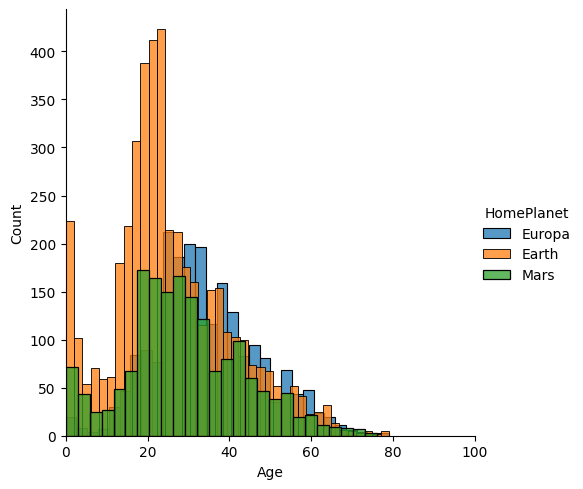

In [ ]:
(sns
.FacetGrid(train_data, hue = "HomePlanet", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend()

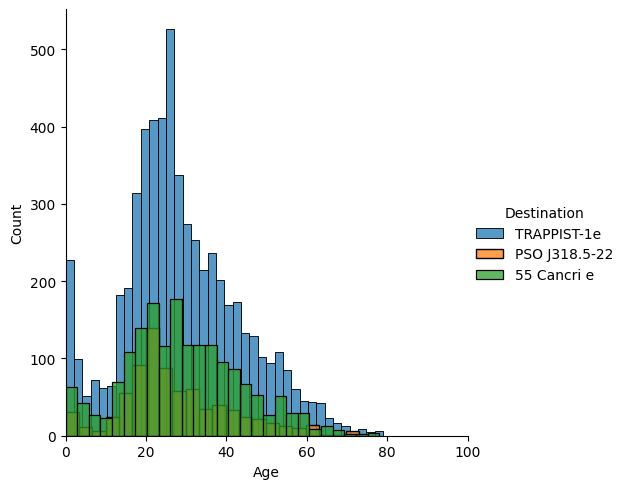

In [ ]:
(sns
.FacetGrid(train_data, hue = "Destination", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend()

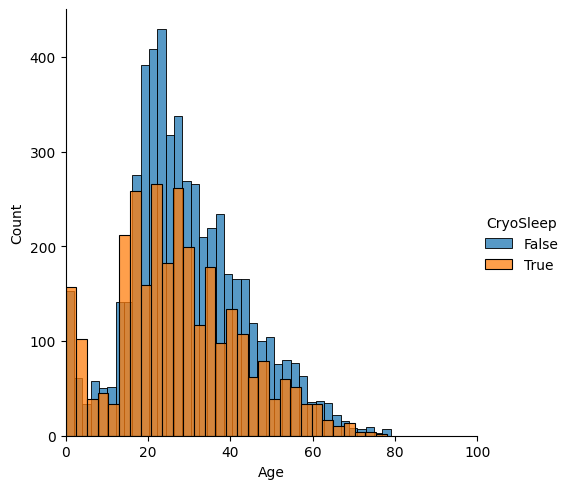

In [ ]:
(sns
.FacetGrid(train_data, hue = "CryoSleep", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend()

## **Observe**
- Passengers under 13 years of age do not have any spend
- There aren't any VIP passengers under 18 years age

## **VIP**

False    0.976561
True     0.023439
Name: VIP, dtype: float64


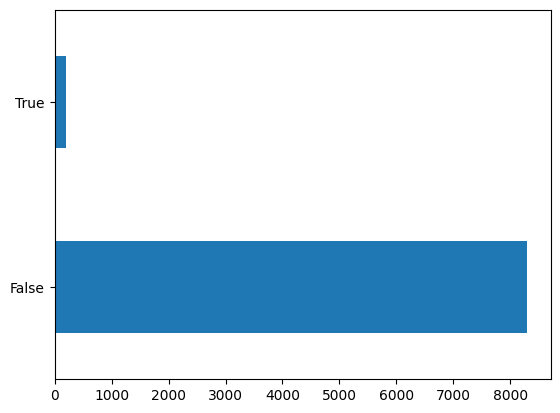

In [ ]:
print(train_data.VIP.value_counts(normalize=True))
train_data.VIP.value_counts().plot.barh();

VIP    Transported
False  True           0.506332
       False          0.493668
True   False          0.618090
       True           0.381910
Name: Transported, dtype: float64


<Axes: xlabel='VIP', ylabel='Transported'>

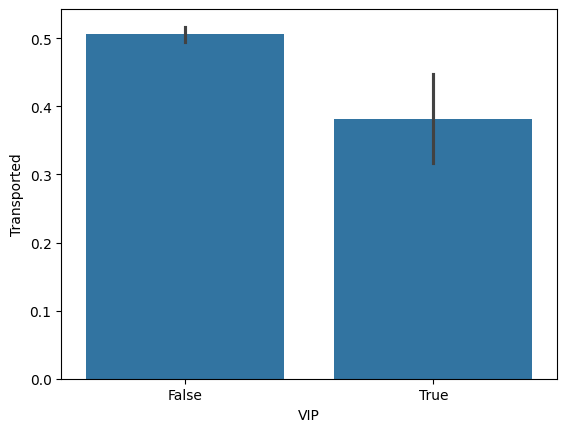

In [ ]:
print(train_data.groupby("VIP")["Transported"].value_counts(normalize = True))
sns.barplot(x = "VIP", y= "Transported", data = train_data)

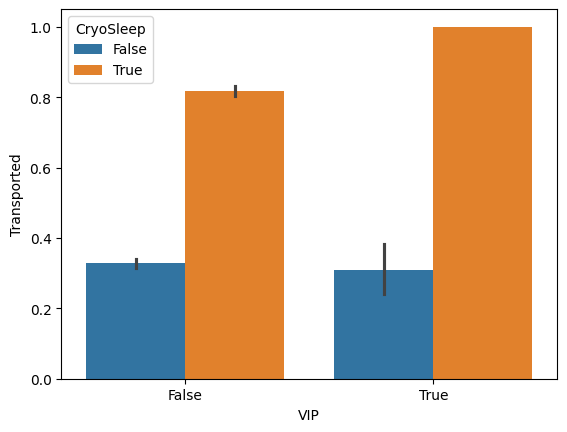

In [ ]:
sns.barplot(x = "VIP", y= "Transported", hue = "CryoSleep",data = train_data);

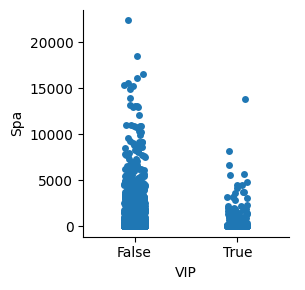

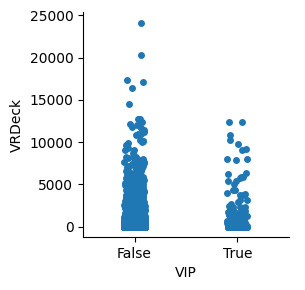

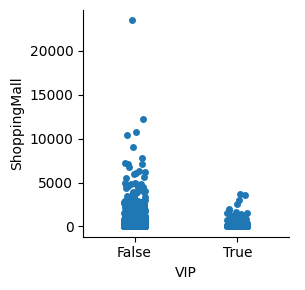

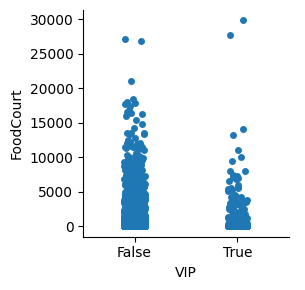

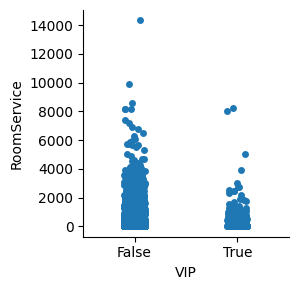

In [ ]:
sns.catplot(x = "VIP", y = "Spa", data = train_data,height=3)
plt.show()
sns.catplot(x = "VIP", y = "VRDeck", data = train_data,height=3)
plt.show()
sns.catplot(x = "VIP", y = "ShoppingMall", data = train_data,height=3)
plt.show()
sns.catplot(x = "VIP", y = "FoodCourt", data = train_data,height=3)
plt.show()
sns.catplot(x = "VIP", y = "RoomService", data = train_data,height=3)
plt.show()

Destination    VIP  
55 Cancri e    False    1692
               True       65
PSO J318.5-22  False     756
               True       18
TRAPPIST-1e    False    5667
               True      114
Name: VIP, dtype: int64


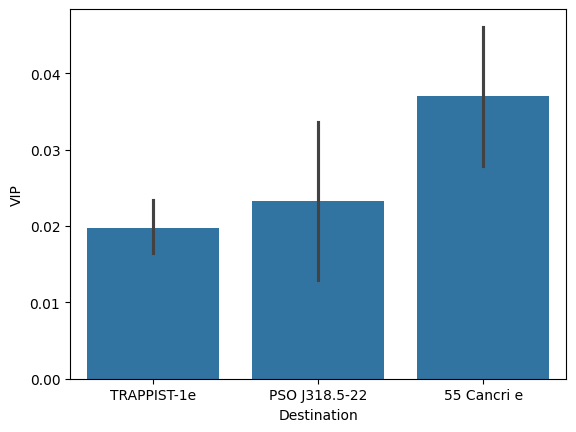

In [ ]:
print(train_data.groupby("Destination")["VIP"].value_counts())
sns.barplot(x = "Destination", y= "VIP", data = train_data);

HomePlanet  VIP  
Earth       False    4487
Europa      False    1958
            True      131
Mars        False    1653
            True       63
Name: VIP, dtype: int64


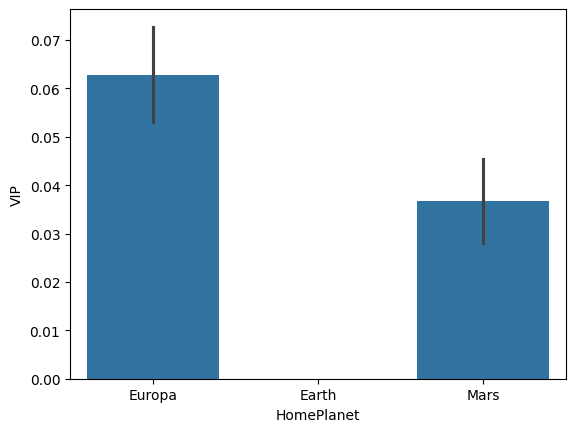

In [ ]:
print(train_data.groupby("HomePlanet")["VIP"].value_counts())
sns.barplot(x = "HomePlanet", y= "VIP", data = train_data);

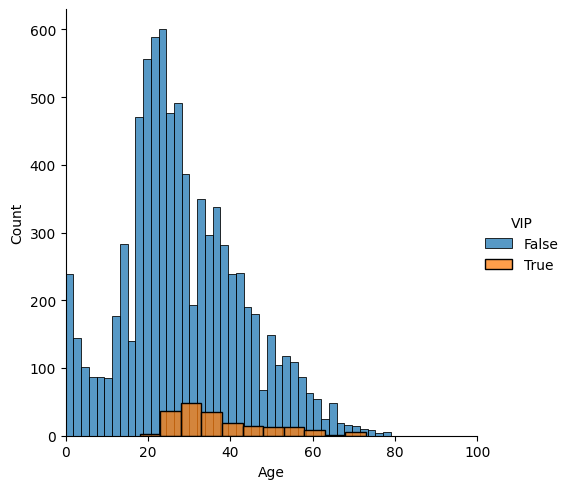

In [ ]:
(sns
.FacetGrid(train_data, hue = "VIP", height=5,xlim=(0,100))
.map(sns.histplot, "Age")).add_legend()

## **Observe**
- Passengers of VIP percent 2 in all passengers.
- Transported rate of not VIP passengers are higher
- Higher spend for non-VIP travellers, excluding foodcourt
- There aren't VIP passenger in Earth and There aren't any VIP passengers under 18 years age

## **Feature Engineering and Missing Values**

In [ ]:
train_data["Transported"].isnull().values.any()

False

In [ ]:
# Transported convert into 1-0 with check
print(train_data["Transported"].value_counts())
train_data["Transported"] = [1 if i == True else 0 for i in train_data["Transported"]]
print(train_data["Transported"].value_counts())

True     4378
False    4315
Name: Transported, dtype: int64
1    4378
0    4315
Name: Transported, dtype: int64


In [ ]:
# And we can merge train and test data for feature engineering and missing values
AllData = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
AllData

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


## **VIP**

In [ ]:
# There aren't VIP passenger in Earth and There aren't any VIP passengers under 18 years age.
# Some of the missing values can be filled according to this determination
AllData["VIP"].isnull().sum()

296

In [ ]:
AgeVIPIndex = AllData[(AllData["VIP"].isnull() == True) & (AllData["Age"]<18)][["VIP"]].index

In [ ]:
AllData["VIP"][AgeVIPIndex] = False

In [ ]:
EarthVIPIndex = AllData[(AllData["VIP"].isnull() == True) & (AllData["HomePlanet"]=="Earth")][["VIP"]].index

In [ ]:
AllData["VIP"][EarthVIPIndex] = False

In [ ]:
AllData["VIP"].isnull().sum()

125

## **Spending**

In [ ]:
# Passengers under 13 years of age  and sleeping passengers don't have any spend
#  Some of the missing values can be filled according to this determination
print(AllData["Spa"].isnull().sum())
print(AllData["VRDeck"].isnull().sum())
print(AllData["ShoppingMall"].isnull().sum())
print(AllData["FoodCourt"].isnull().sum())
print(AllData["RoomService"].isnull().sum())

284
268
306
289
263


In [ ]:
#Define func for filling of missing values
def FillSpend(dataset, feature):
    spend_index = dataset[
        (dataset[feature].isnull() == True) &
        ((dataset["Age"]<13) | (dataset["CryoSleep"] == True))
    ].index
    dataset[feature][spend_index] = 0

In [ ]:
spend_list = ["Spa", "RoomService", "FoodCourt", "VRDeck", "ShoppingMall"]
for i in spend_list:
    FillSpend(AllData, i)

In [ ]:
#check
print(AllData["Spa"].isnull().sum())
print(AllData["VRDeck"].isnull().sum())
print(AllData["ShoppingMall"].isnull().sum())
print(AllData["FoodCourt"].isnull().sum())
print(AllData["RoomService"].isnull().sum())

166
150
163
171
162


## **Name and Passenger Id**

In [ ]:
# We can split of name as name and surname after can remove name
# Also missing values of name can be filled group_ıd

In [ ]:
AllData["GroupId"] = AllData.PassengerId.str.split("_", expand = True)[0].astype(int)
AllData["GroupNumber"] = AllData.PassengerId.str.split("_", expand = True)[1].astype(int)

In [ ]:
AllData.drop(["PassengerId"], axis = 1, inplace = True)


In [ ]:
AllData["Surname"] = AllData["Name"].str.split(" ", expand = True)[1]

In [ ]:
AllData.drop(["Name"], axis = 1, inplace = True)

In [ ]:
# Those with group number greater than 1 have the same group id number.
#Therefore, considering that they are the same family their surnames can be filled in according to the previous sample.
SurnameIndex = AllData[(AllData["GroupNumber"]>1) & (AllData["Surname"].isnull() == True)].index

In [ ]:
for i in SurnameIndex:
    AllData["Surname"][i] = AllData["Surname"][i-1]

## **CryoSleep**

In [ ]:
AllData[AllData["CryoSleep"].isnull() == True]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,GroupNumber,Surname
92,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,1.0,99,2,Connelson
98,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,0.0,105,1,Cleachrand
104,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,0.0,110,2,Bootious
111,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,1.0,115,1,Pead
152,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,1.0,173,1,Grifford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,Mars,NaN,F/1790/P,55 Cancri e,20.0,False,0.0,0.0,0.0,0.0,0.0,NaN,8705,1,Gen
12801,Europa,NaN,C/295/P,TRAPPIST-1e,27.0,False,0.0,2182.0,7.0,2582.0,19.0,NaN,8925,6,Pabler
12902,Europa,NaN,NaN,TRAPPIST-1e,41.0,False,0.0,1998.0,0.0,1023.0,867.0,NaN,9138,1,Trupistic
12923,Earth,NaN,F/1776/S,TRAPPIST-1e,14.0,False,0.0,0.0,NaN,1377.0,29.0,NaN,9182,1,Gainebergan


In [ ]:
# Those who make any spending are not asleep.Therefore missing values can be filled this situation

In [ ]:
SleepIndex = AllData[
    (AllData["CryoSleep"].isnull() == True) &
    (
        (AllData["Spa"]>0) | (AllData["RoomService"]>0)
        | (AllData["FoodCourt"]>0) | (AllData["VRDeck"]>0) | (AllData["ShoppingMall"]>0)
    )
].index

In [ ]:
AllData["CryoSleep"][SleepIndex] = False

## **HomePlanet / Destination**

In [ ]:
# Those with group number greater than 1 have the same group id number.
#Therefore, considering that they are the same family their HomePlanet and Destination can be filled in according to the previous sample.

In [ ]:
HPIndex=AllData[(AllData["GroupNumber"]>1) & (AllData["HomePlanet"].isnull() == True)].index
DestIndex = AllData[(AllData["GroupNumber"]>1) & (AllData["Destination"].isnull() == True)].index

In [ ]:
for i in HPIndex:
    AllData["HomePlanet"][i] = AllData["HomePlanet"][i-1]
for i in DestIndex:
    AllData["Destination"][i] = AllData["Destination"][i-1]

## **Cabin**

In [ ]:
# We can split Cabin Deck and Side
AllData["CabinDeck"] = AllData.Cabin.str.split("/", expand = True)[0]
AllData["CabinSide"] = AllData.Cabin.str.split("/", expand = True)[2]

In [ ]:
AllData.drop(["Cabin"],axis = 1, inplace = True)

In [ ]:
# Those with group number greater than 1 have the same group id number.
#Therefore, considering that they are the same family their CabinDeck and CabinSide can be filled in according to the previous sample.

In [ ]:
DecIndex=AllData[(AllData["GroupNumber"]>1) & (AllData["CabinDeck"].isnull() == True)].index
SideIndex = AllData[(AllData["GroupNumber"]>1) & (AllData["CabinSide"].isnull() == True)].index

In [ ]:
for i in DecIndex:
    AllData["CabinDeck"][i] = AllData["CabinDeck"][i-1]
for i in SideIndex:
    AllData["CabinSide"][i] = AllData["CabinSide"][i-1]

## **Convert Categorical**

In [ ]:
y = AllData.pop("Transported")

In [ ]:
AllData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12765 non-null  object 
 1   CryoSleep     12834 non-null  object 
 2   Destination   12777 non-null  object 
 3   Age           12700 non-null  float64
 4   VIP           12845 non-null  object 
 5   RoomService   12808 non-null  float64
 6   FoodCourt     12799 non-null  float64
 7   ShoppingMall  12807 non-null  float64
 8   Spa           12804 non-null  float64
 9   VRDeck        12820 non-null  float64
 10  GroupId       12970 non-null  int64  
 11  GroupNumber   12970 non-null  int64  
 12  Surname       12766 non-null  object 
 13  CabinDeck     12759 non-null  object 
 14  CabinSide     12759 non-null  object 
dtypes: float64(6), int64(2), object(7)
memory usage: 1.5+ MB


In [ ]:
#Label Encoder
EncFeatures = [AllData.select_dtypes(["object"]).columns]

lbe = OrdinalEncoder()
for feature in EncFeatures:
    AllData[feature]= lbe.fit_transform(AllData[feature])

In [ ]:
AllData

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
0,1.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1551.0,1.0,0.0
1,0.0,0.0,2.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,2,1,2289.0,5.0,1.0
2,1.0,0.0,2.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,3,1,2153.0,0.0,1.0
3,1.0,0.0,2.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,3,2,2153.0,0.0,1.0
4,0.0,0.0,2.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,4,1,1924.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,1.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,9266,2,1657.0,6.0,1.0
12966,0.0,0.0,2.0,42.0,0.0,0.0,847.0,17.0,10.0,144.0,9269,1,1937.0,NaN,NaN
12967,2.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9271,1,1707.0,3.0,0.0
12968,1.0,0.0,NaN,NaN,0.0,0.0,2680.0,0.0,0.0,523.0,9273,1,496.0,3.0,0.0


## **Remaining Missing Value with KNN**

In [ ]:
# Even if some missing samples have been filled in the above operations.
# there are still missing samples. For others, predictive value assignment can be used

In [ ]:
var_names = list(AllData)
n_df = np.array(AllData)
dff = knnimput.KNN(k = 4).complete(n_df)

Imputing row 1/12970 with 0 missing, elapsed time: 35.387
Imputing row 101/12970 with 0 missing, elapsed time: 35.389
Imputing row 201/12970 with 0 missing, elapsed time: 35.391
Imputing row 301/12970 with 0 missing, elapsed time: 35.393
Imputing row 401/12970 with 0 missing, elapsed time: 35.395
Imputing row 501/12970 with 0 missing, elapsed time: 35.397
Imputing row 601/12970 with 0 missing, elapsed time: 35.399
Imputing row 701/12970 with 0 missing, elapsed time: 35.401
Imputing row 801/12970 with 0 missing, elapsed time: 35.403
Imputing row 901/12970 with 0 missing, elapsed time: 35.405
Imputing row 1001/12970 with 0 missing, elapsed time: 35.407
Imputing row 1101/12970 with 0 missing, elapsed time: 35.409
Imputing row 1201/12970 with 0 missing, elapsed time: 35.410
Imputing row 1301/12970 with 1 missing, elapsed time: 35.412
Imputing row 1401/12970 with 0 missing, elapsed time: 35.414
Imputing row 1501/12970 with 0 missing, elapsed time: 35.415
Imputing row 1601/12970 with 1 missi

In [ ]:
AllData = pd.DataFrame(dff, columns=var_names)

In [ ]:
AllData.isnull().values.any()

False

### **MEstimate Encoder**

In [ ]:
# Some categorical variables are multicategorical, so it's appropriate to use MEstimator

In [ ]:
print(AllData["GroupId"].nunique())
print(AllData["GroupNumber"].nunique())
print(AllData["Surname"].nunique())
print(AllData["CabinDeck"].nunique())

40
8
85
11


In [ ]:
encoders = MEstimateEncoder(cols = ["GroupId", "GroupNumber", "Surname", "CabinDeck"], m=4.0)
encoders.fit(AllData, y)

MEstimateEncoder(cols=['GroupId', 'GroupNumber', 'Surname', 'CabinDeck'], m=4.0)

In [ ]:
AllData = encoders.transform(AllData)

In [ ]:
print(AllData["GroupId"].nunique())
print(AllData["GroupNumber"].nunique())
print(AllData["Surname"].nunique())
print(AllData["CabinDeck"].nunique())

39
8
85
11


## **Outlier Samples and Normalize**

In [ ]:
#The variance of variables outlier samples will be selected with LocalOutlierFactor

In [ ]:
clf = LocalOutlierFactor(n_neighbors=5)
clf.fit_predict(AllData)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
clf_scores = clf.negative_outlier_factor_

In [ ]:
np.sort(clf_scores)[0:40]

array([-4.49680327e+04, -2.18714916e+04, -1.84457421e+04, -1.64651446e+04,
       -4.06596128e+03, -4.06596128e+03, -4.06596128e+03, -4.06596128e+03,
       -4.06596128e+03, -2.72491137e+02, -8.29004011e+01, -5.74774266e+01,
       -3.55850120e+01, -2.20235369e+01, -2.02475834e+01, -2.01893982e+01,
       -1.96362146e+01, -1.87844393e+01, -1.87586559e+01, -1.37105322e+01,
       -1.23904282e+01, -1.11447274e+01, -6.05069756e+00, -5.86385725e+00,
       -5.83601560e+00, -5.74119052e+00, -5.66782682e+00, -5.39919510e+00,
       -5.27123975e+00, -5.09489467e+00, -4.89836263e+00, -4.73774225e+00,
       -4.52369785e+00, -4.50982370e+00, -4.39920312e+00, -4.31287427e+00,
       -4.27344278e+00, -4.26302956e+00, -4.11560578e+00, -4.10814179e+00])

In [ ]:
thresold_value = np.sort(clf_scores)[18]

In [ ]:
outlier_samples = AllData[clf_scores<thresold_value].to_records(index = False)

In [ ]:
outlier_samples[:]= AllData[clf_scores == thresold_value].to_records(index = False)

In [ ]:
 AllData[clf_scores<thresold_value] = pd.DataFrame(outlier_samples, index = AllData[clf_scores<thresold_value].index)

In [ ]:
#check
AllData[clf_scores<thresold_value]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,GroupNumber,Surname,CabinDeck,CabinSide
223,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
290,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
776,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
1026,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
2210,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
2266,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
3063,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
3300,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
3388,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0
4172,2.0,0.0,2.0,27.0,0.0,0.0,0.0,0.0,0.0,5.705914,0.000765,0.475971,0.205675,0.358208,0.0


In [ ]:
#Normalize
AllData = AllData.apply(lambda x: (x-np.min(x)) / (np.max(x)-np.min(x)))

### **Models**

**Train-Test Split**

In [ ]:
# The dataset will be restored to premerger state
# It will then be split into train and test for validation

In [ ]:
train_data = AllData.iloc[:8693]

In [ ]:
y.dropna(inplace = True)
train_data["Transported"] = y

In [ ]:
test_data = AllData.iloc[8693:]

In [ ]:
y = train_data.pop("Transported")

In [ ]:
X = train_data

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=7)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6085, 15)
(2608, 15)
(6085,)
(2608,)


In [ ]:
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

1.0    0.504026
0.0    0.495974
Name: Transported, dtype: float64
1.0    0.502684
0.0    0.497316
Name: Transported, dtype: float64


In [ ]:
test_data.index = np.arange(0,4277)

### **KNN**

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
#knn_params = {
    #"n_neighbors": range(1,51)
    #"weights": ["uniform", "distance"]
    #"leaf_size":range(1,51)
#}

In [ ]:
#knn_cv = GridSearchCV(knn, knn_params, cv = 5, n_jobs=-1, verbose =2)
#knn_cv.fit(X_train, y_train)

In [ ]:
#knn_cv.best_params_

In [ ]:
knn_tuned= KNeighborsClassifier(
    n_neighbors=5,
    weights="distance",
    leaf_size=1
)
knn_tuned.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=1, weights='distance')

In [ ]:
print("KNN CV Accuracy Score: %.4f"% cross_val_score(knn_tuned, X_test, y_test,cv = 5, scoring = "accuracy").mean())

KNN CV Accuracy Score: 0.9176


## **Random Forest**

In [ ]:
rf = RandomForestClassifier(random_state=1)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [ ]:
#rf_params = {
    #"n_estimators": [10,20,50,100,200,500,1000]
    #"max_depth": range(1,41)
    #"max_features": range(1,21)
    #"min_samples_split": range(1,11)
#}

In [ ]:
#rf_cv = GridSearchCV(rf, rf_params, cv = 5, n_jobs=-1, verbose = 2)
#rf_cv.fit(X_train, y_train)

In [ ]:
#rf_cv.best_params_

In [ ]:
rf_tuned = RandomForestClassifier(
    random_state=1,
    n_estimators=100,
    max_depth=18,
    max_features=13,
    min_samples_split=3
)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, max_features=13, min_samples_split=3,
                       random_state=1)

In [ ]:
print("RF CV Accuracy Score: %.4f"% cross_val_score(rf_tuned, X_test, y_test,cv = 5, scoring = "accuracy").mean())

RF CV Accuracy Score: 0.9440


## **LightGBM**

In [ ]:
lgb = LGBMClassifier(random_state=1,
                    force_col_wise=True)

In [ ]:
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3067, number of negative: 3018
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504026 -> initscore=0.016106
[LightGBM] [Info] Start training from score 0.016106


LGBMClassifier(force_col_wise=True, random_state=1)

In [ ]:
#lgb_params = {
    #"n_estimators": [20,50,100,200,500]
    #"subsample":np.arange(0,1,0.01)
    #"learning_rate": np.arange(0,1,0.01)
    #"max_depth": range(1,51)
    #"min_child_samples": range(1,20)
    #"num_leaves": range(1,31)
#}

In [ ]:
#lgb_cv = GridSearchCV(lgb, lgb_params, cv = 5, n_jobs=-1, verbose=2)
#lgb_cv.fit(X_train, y_train)

In [ ]:
#lgb_cv.best_params_

In [ ]:
lgb_tuned = LGBMClassifier(random_state=1,
                           n_estimators=50,
                           subsample=0.01,
                           learning_rate=0.05,
                           max_depth = 6,
                           min_child_samples=2,
                           num_leaves = 20,

                            force_col_wise=True)
lgb_tuned.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3067, number of negative: 3018
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 6085, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504026 -> initscore=0.016106
[LightGBM] [Info] Start training from score 0.016106


LGBMClassifier(force_col_wise=True, learning_rate=0.05, max_depth=6,
               min_child_samples=2, n_estimators=50, num_leaves=20,
               random_state=1, subsample=0.01)

In [ ]:
print("LGB CV Accuracy Score: %.4f"% cross_val_score(lgb_tuned, X_test, y_test,cv = 5, scoring = "accuracy").mean())

[LightGBM] [Info] Number of positive: 1049, number of negative: 1037
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502876 -> initscore=0.011505
[LightGBM] [Info] Start training from score 0.011505
[LightGBM] [Info] Number of positive: 1049, number of negative: 1037
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502876 -> initscore=0.011505
[LightGBM] [Info] Start training from score 0.011505
[LightGBM] [Info] Number of positive: 1048, number of negative: 1038
[LightGBM] [Info] Total Bins 1478
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502397 -> initscore=0.009588
[LightGBM] [Info] Start training from score 0.009588
[LightGBM] [Info] N

## **XGB**

In [ ]:
xgb = XGBClassifier(random_state = 1)

In [ ]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [ ]:
#xgb_params = {
    #"n_estimators": [20,50,100,200,500]
    #"max_depth": range(1,51)
    #"subsample": [0.1,0.01,0.2,0.5,0.6,0.8]
    #"learning_rate": [0.1,0.01,0.2,0.02,0.5]
#}

In [ ]:
#xgb_cv = GridSearchCV(xgb, xgb_params, cv = 5, n_jobs=-1, verbose=2)
#xgb_cv.fit(X_train, y_train)

In [ ]:
#xgb_cv.best_params_

In [ ]:
xgb_tuned = XGBClassifier(n_estimators = 20,
                          max_depth = 2,
                          subsample = 0.5,
                          learning_rate = 0.1,
                         random_state = 1)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [ ]:
print("XGB CV Accuracy Score: %.4f"% cross_val_score(xgb_tuned, X_test, y_test,cv = 5, scoring = "accuracy").mean())

XGB CV Accuracy Score: 0.9256


## **GBM**

In [ ]:
gb = GradientBoostingClassifier(random_state=1)

In [ ]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1)

In [ ]:
#gb_params = {
        #"n_estimators": [20,50,100,200,500]
       #"learning_rate": [0.1,0.01,0.001,0.2,0.02,0.3,0.5,0.7]
       #"max_depth": range(1,11)
        #"min_samples_split": range(1,11)

#}

In [ ]:
#gb_cv = GridSearchCV(gb, gb_params, cv = 5, n_jobs=-1, verbose=2)
#gb_cv.fit(X_train, y_train)

In [ ]:
#gb_cv.best_params_

In [ ]:
gb_tuned = GradientBoostingClassifier(n_estimators=200,
                                      learning_rate=0.2,
                                      max_depth=5,
                                      min_samples_split=3,
                                     random_state=1)
gb_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_split=3,
                           n_estimators=200, random_state=1)

In [ ]:
print("GB CV Accuracy Score: %.4f"% cross_val_score(gb_tuned, X_test, y_test,cv = 5, scoring = "accuracy").mean())

GB CV Accuracy Score: 0.9432


### **Model Selection (Ensemble Model)**

In [ ]:
# We obtained the highest scores in GB,LGB and RF.
# Since the scores of these models are close to each other, they can be used as ensembles.

In [ ]:
VotingC = VotingClassifier(
    estimators=[("gb",gb_tuned),("lgb",lgb_tuned), ("rf", rf_tuned)],voting="soft", n_jobs=-1
)
VotingC.fit(X_train, y_train)

VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         max_depth=5,
                                                         min_samples_split=3,
                                                         n_estimators=200,
                                                         random_state=1)),
                             ('lgb',
                              LGBMClassifier(force_col_wise=True,
                                             learning_rate=0.05, max_depth=6,
                                             min_child_samples=2,
                                             n_estimators=50, num_leaves=20,
                                             random_state=1, subsample=0.01)),
                             ('rf',
                              RandomForestClassifier(max_depth=18,
                                                     max_features=13,
                                                     min_samples_split=3,
                                                     random_state=1))],
                 n_jobs=-1, voting='soft')

In [ ]:
print("Voting CV Accuracy Score: %.4f"% cross_val_score(VotingC, X_test, y_test,cv = 5, scoring = "accuracy").mean())

Voting CV Accuracy Score: 0.9467


In [ ]:
y_pred = VotingC.predict(X_test)

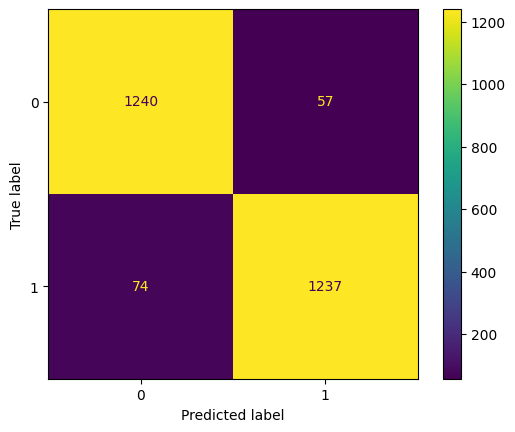

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

In [ ]:
predictions = VotingC.predict(test_data)
submisssion["Transported"] = predictions
submisssion.head()

,PassengerId,Transported
0,0013_01,1.0
1,0018_01,0.0
2,0019_01,1.0
3,0021_01,1.0
4,0023_01,1.0


In [ ]:
submisssion.Transported=submisssion.Transported.apply(lambda x: True if x==1 else False)
submisssion.Transported

0        True
1       False
2        True
3        True
4        True
        ...  
4272     True
4273    False
4274     True
4275     True
4276     True
Name: Transported, Length: 4277, dtype: bool

In [ ]:
submisssion.to_csv("submission.csv",index=False)